In [1]:
import os 
import json 
import cv2 
import numpy as np 
from time import time 
from pprint import pprint 
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image 
import torch 
import torchvision 
from torchvision import transforms as T 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor 
from vision.mrcnn.data_preparation import AileenDataset

In [2]:
ROOT_TEST = "/media/mfan/SEAGATE/Aileen_data/MRCNN/test/"
BATCH_SIZE = 6
NUM_CLASSES = 5 + 1
THRESHOLD_CONF = 0.5
DEVICE = "cuda"
TEST = True
CHECKPOINT_RESUME = os.path.join("./vision/mrcnn/", "latest_model.pth.tar")

In [3]:
valid_dataset = AileenDataset(ROOT_TEST, 1000, transform=None)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=6,
    collate_fn=lambda x: tuple(zip(*x)),
    pin_memory=True,
)

In [4]:
hidden_layer = 256
model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
model_ft.to(DEVICE)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [5]:
def bb_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [6]:
if TEST:
    print("running test...")
    for param in model_ft.parameters():
        param.requires_grad = False
    model_ft.eval()
    eval_hist = []
    print("loading: {}".format(CHECKPOINT_RESUME))
    model_ft.load_state_dict(torch.load(CHECKPOINT_RESUME))

running test...
loading: ./vision/mrcnn/latest_model.pth.tar


predict time: 0.107 s
***************************
gt labels =  [3]   predicted labels =  [3]
gt box =  [[214. 169. 256. 211.]]
pd box =  [[213. 169. 255. 211.]]
Structural Similarity Index (SSIM): 0.9992416057090328
***************************


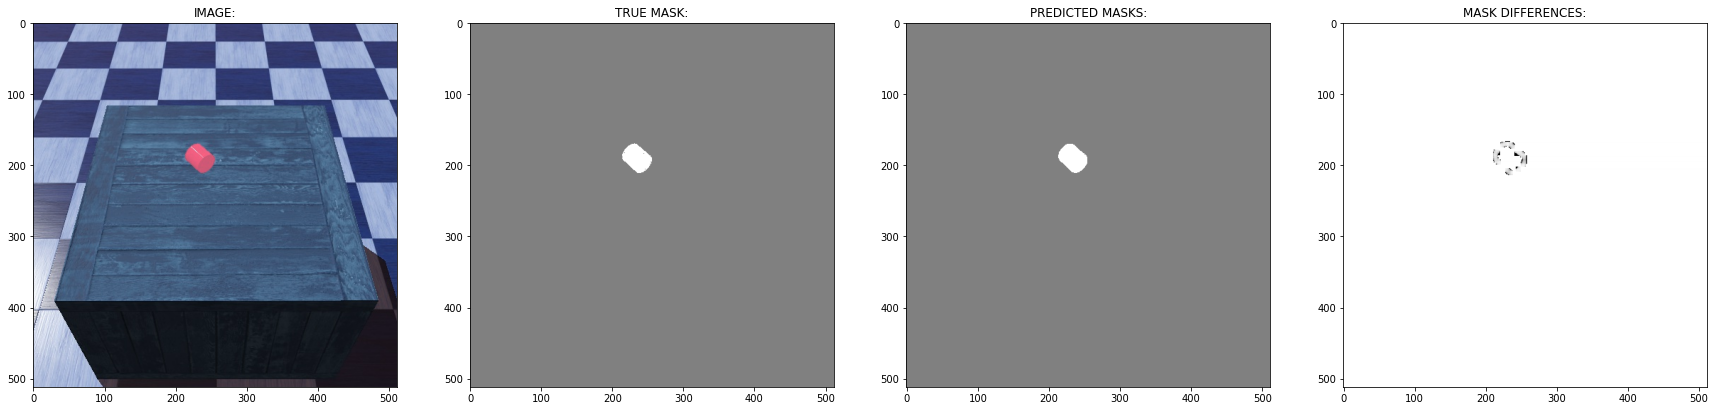

In [7]:
for i in range(1):
    rid = np.random.randint(0, len(valid_dataset))
    img_, target_ = valid_dataset.__getitem__(rid)
    img = (img_ * 255).cpu().detach().numpy().astype(int)
    img = np.moveaxis(img, 0, -1)
    true_masks = target_["masks"].cpu().detach().numpy()
    true_labels = target_["labels"].cpu().detach().numpy()
    true_bboxes = target_["boxes"].cpu().detach().numpy()
    fig, ax = plt.subplots(1, 4, figsize=(30, 12))
    ax[0].imshow(img)
    t0 = time()
    val_pred = model_ft(torch.unsqueeze(img_, 0).cuda())[0]
    print("predict time:", round(time() - t0, 3), "s")
    
    pred_boxes = val_pred['boxes'].cpu().detach().numpy()
    pred_labels = val_pred['labels'].cpu().detach().numpy()
    pred_scores = val_pred['scores'].cpu().detach().numpy()
    pred_masks = val_pred['masks'].cpu().detach().numpy()[:, 0]

    pred_valid_idx = pred_scores > THRESHOLD_CONF
    pred_boxes = pred_boxes[pred_valid_idx]
    pred_labels = pred_labels[pred_valid_idx]
    pred_scores = pred_scores[pred_valid_idx]
    pred_masks = pred_masks[pred_valid_idx]
    pred_mask_single = np.sum(pred_masks, axis=0)
    
    img = img.astype(np.uint8)
    description = "Blue bbox is the ground-truth, green bbox is the prediction"
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, description, (10, 50), font, 1, (0, 0, 255), 1, cv2.LINE_AA)
    
    for i in range(len(pred_boxes)):
        tx = int(pred_boxes[i][0])
        ty = int(pred_boxes[i][1])
        bx = int(pred_boxes[i][2])
        by = int(pred_boxes[i][3])
        pred_boxes[i][0] = tx
        pred_boxes[i][1] = ty
        pred_boxes[i][2] = bx
        pred_boxes[i][3] = by
        pred_boxes[i][0]
        cx = (bx + tx) / 2
        cy = (by + ty) / 2
        cv2.rectangle(img, (int(tx), int(ty)), (int(bx), int(by)), (0, 255, 0), 2, 2)
        gt_tx = int(true_bboxes[i][0])
        gt_ty = int(true_bboxes[i][1])
        gt_bx = int(true_bboxes[i][2])
        gt_by = int(true_bboxes[i][3])
        gt_cx = (gt_bx + gt_tx) / 2
        gt_cy = (gt_by + gt_ty) / 2
        cv2.rectangle(img, (int(gt_tx), int(gt_ty)), (int(gt_bx), int(gt_by)), (255, 0, 0), 2, 2)
        
    cv2.imshow("predicted bbox", img)
    cv2.waitKey(0)
    tmp1 = np.zeros((512, 512))
    tmp2 = np.zeros((512, 512))
    for i in range(len(true_masks)):
        ax[1].imshow(true_masks[i], alpha=0.5, cmap='gray')
        tmp = cv2.threshold(true_masks[i], 0, 255, cv2.THRESH_BINARY)[1]
        tmp1 += tmp 
    for i in range(len(pred_masks)):
        ax[2].imshow(pred_masks[i] > THRESHOLD_CONF, alpha=0.5, cmap='gray') #  
        tmp = cv2.threshold(pred_masks[i], 0.5, 255, cv2.THRESH_BINARY)[1]
        tmp2 += tmp 
    
    (score, diff) = compare_ssim(tmp1, tmp2, full=True)
    diff = (diff * 255).astype("uint8")
    
    ax[3].imshow(diff, cmap='gray')
    ax[0].set_title("IMAGE:")
    ax[1].set_title("TRUE MASK:")
    ax[2].set_title("PREDICTED MASKS:")
    ax[3].set_title("MASK DIFFERENCES:")
    print("***************************")
    print("gt labels = ", true_labels, " ", "predicted labels = ", pred_labels)
    print("gt box = ", true_bboxes)
    print("pd box = ", pred_boxes)
    print("Structural Similarity Index (SSIM): {}".format(score))
    print("***************************")
    plt.show()

In [8]:
acc = 0
iou = 0
cnt = 0
for i in range(0, len(valid_dataset)):
    rid = i
    img_, target_ = valid_dataset.__getitem__(rid)
    true_masks = target_["masks"].cpu().detach().numpy()
    true_labels = target_["labels"].cpu().detach().numpy()
    true_bboxes = target_["boxes"].cpu().detach().numpy()
    t0 = time()
    val_pred = model_ft(torch.unsqueeze(img_, 0).cuda())[0]
    
    pred_boxes = val_pred['boxes'].cpu().detach().numpy()
    pred_labels = val_pred['labels'].cpu().detach().numpy()
    pred_scores = val_pred['scores'].cpu().detach().numpy()
    pred_masks = val_pred['masks'].cpu().detach().numpy()[:, 0]

    pred_valid_idx = pred_scores > THRESHOLD_CONF
    pred_boxes = pred_boxes[pred_valid_idx]
    pred_labels = pred_labels[pred_valid_idx]
    pred_scores = pred_scores[pred_valid_idx]
    pred_masks = pred_masks[pred_valid_idx]
    pred_mask_single = np.sum(pred_masks, axis=0)
    cnt += len(pred_labels)
    for i in range(len(pred_boxes)):
        tx = int(pred_boxes[i][0])
        ty = int(pred_boxes[i][1])
        bx = int(pred_boxes[i][2])
        by = int(pred_boxes[i][3])
        pred_boxes[i][0] = tx
        pred_boxes[i][1] = ty
        pred_boxes[i][2] = bx
        pred_boxes[i][3] = by
        for j in range(len(true_bboxes)):
            if bb_iou(pred_boxes[i], true_bboxes[j]) > .7:
                iou += bb_iou(pred_boxes[i], true_bboxes[j])
                if pred_labels[i] == true_labels[j]:
                    acc += 1
    

In [9]:
print("***************************")
print("Classification accuracy = ", acc / cnt)
print("Average IoU = ", iou / cnt)
print("***************************")

***************************
Classification accuracy =  0.9290322580645162
Average IoU =  0.8811774414067858
***************************
